In [46]:
%pip install pandas numpy pennylane

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [47]:
import numpy as np
import matplotlib.pyplot as plt
import  pandas as pd
import seaborn as sns

In [48]:
dataset = pd.read_csv("soil_fertility.csv")
dataset.shape

(880, 13)

In [49]:
dataset.head()

,N,P,K,pH,EC,OC,S,Zn,Fe,Cu,Mn,B,Output
0,138,8.6,560,7.46,0.62,0.70,5.9,0.24,0.31,0.77,8.71,0.11,0
1,213,7.5,338,7.62,0.75,1.06,25.4,0.30,0.86,1.54,2.89,2.29,0
2,163,9.6,718,7.59,0.51,1.11,14.3,0.30,0.86,1.57,2.70,2.03,0
3,157,6.8,475,7.64,0.58,0.94,26.0,0.34,0.54,1.53,2.65,1.82,0
4,270,9.9,444,7.63,0.40,0.86,11.8,0.25,0.76,1.69,2.43,2.26,1


In [50]:
# Low Fertility - 0
# Medium Fertility  - 1
# High Fertility - 2
dataset['Output'].value_counts()

Output
1    440
0    401
2     39
Name: count, dtype: int64

<Axes: >

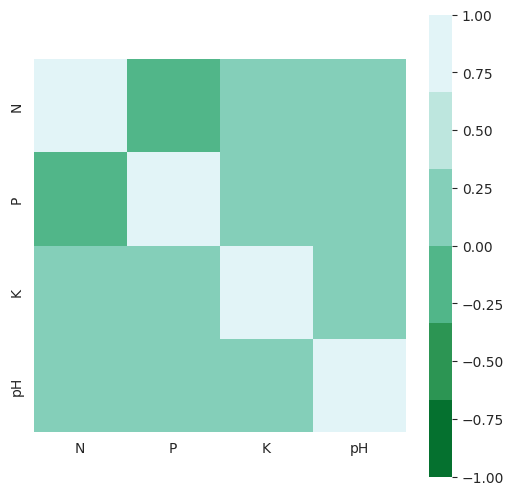

In [51]:
labels = dataset[['Output']]
dataset = dataset.drop(['Output','EC','OC','S','Zn','Fe','Cu','Mn','B'], axis=1)
corr = dataset.corr()
f, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(corr,
    cmap=sns.color_palette("BuGn_r"),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)

In [52]:

features = dataset
features.head()

,N,P,K,pH
0,138,8.6,560,7.46
1,213,7.5,338,7.62
2,163,9.6,718,7.59
3,157,6.8,475,7.64
4,270,9.9,444,7.63


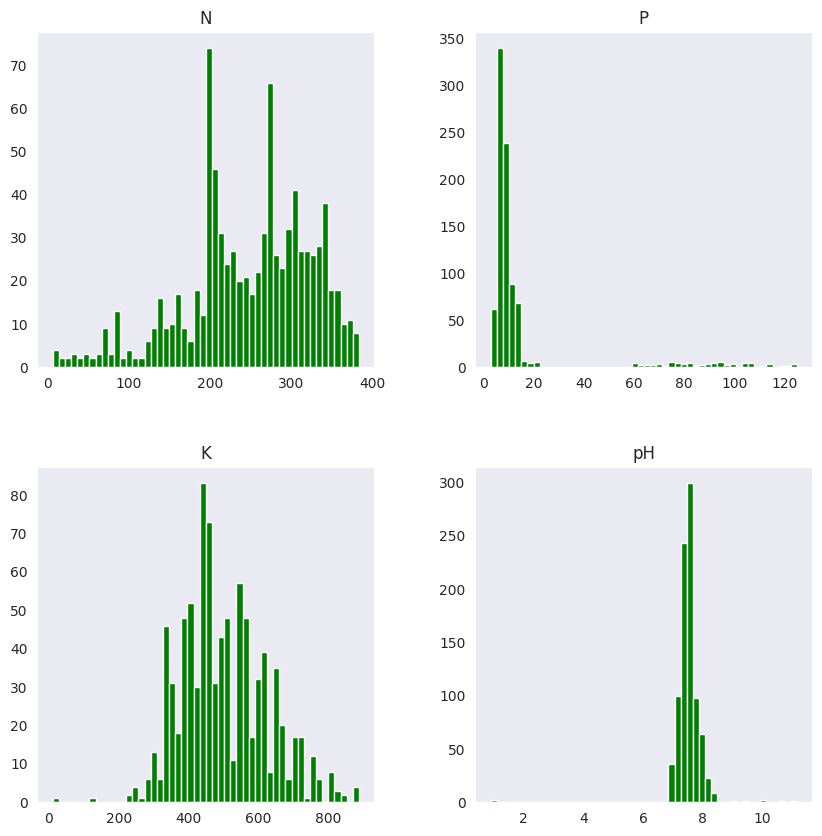

In [53]:
features.hist(bins=50, figsize=(10, 10), color ='green', grid=False)
plt.show()

In [54]:
from sklearn.model_selection import train_test_split

X = features[:100]
y = labels[:100]
trainInput, validationInput, trainTarget, validationTarget = train_test_split(X, y, test_size = 0.1, shuffle=True, random_state = 42)
print("Train Data Shape: ", trainInput.shape)

Train Data Shape:  (90, 4)


In [55]:
# trainTarget = trainTarget.values.ravel()


In [56]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

svcClf = SVC()
svcClf.fit(trainInput, trainTarget)
model = svcClf

/home/24700746/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [57]:
pred = model.predict((validationInput))
model_acc = accuracy_score(validationTarget, pred)
print(type(model).__name__, " accuarcy is ", model_acc)


SVC  accuarcy is  0.8


# Quantum Classifier

/home/24700746/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:737: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y_ = column_or_1d(y, warn=True)


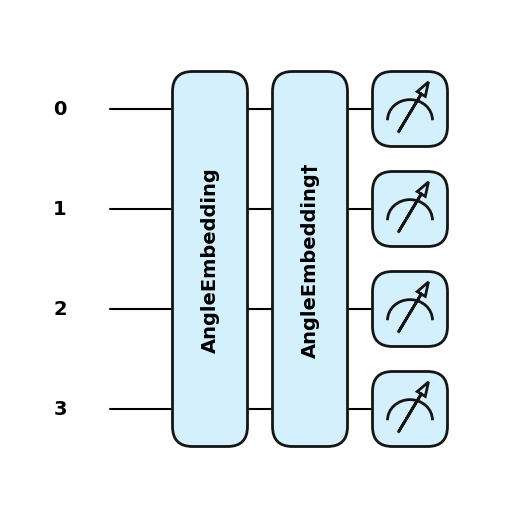

In [58]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score

from sklearn.svm import SVC


scaler = StandardScaler().fit(features)
X_scaled = scaler.transform(features)

#X_scaled = X_scaled[:100]
# scaling the labels to -1, 1 is important for the SVM and the
# definition of a hinge loss
y_scaled = 2 * (labels - 0.5)
#y_scaled = y_scaled[:100]
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size = 0.1, shuffle=True, random_state = 42)

n_qubits = len(X_train[0])





dev_kernel = qml.device("default.qubit", wires=n_qubits)

projector = np.zeros((2 ** n_qubits, 2 ** n_qubits))
projector[0, 0] = 1

@qml.qnode(dev_kernel)
def kernel(x1, x2):
    """The quantum kernel."""
    AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(AngleEmbedding)(x2, wires=range(n_qubits))
    return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))

def kernel_matrix(A, B):
    """Compute the matrix whose entries are the kernel
       evaluated on pairwise data from sets A and B."""
    qml.draw_mpl(kernel, style="pennylane")(A[0],B[0])
    return np.array([[kernel(a, b) for b in B] for a in A])

svm = SVC(kernel=kernel_matrix).fit(X_train, y_train)




(792, 1)
(88, 1)
SVC  accuracy is  0.9090909090909091
[[32  1  0]
 [ 2 48  0]
 [ 1  4  0]]


69696

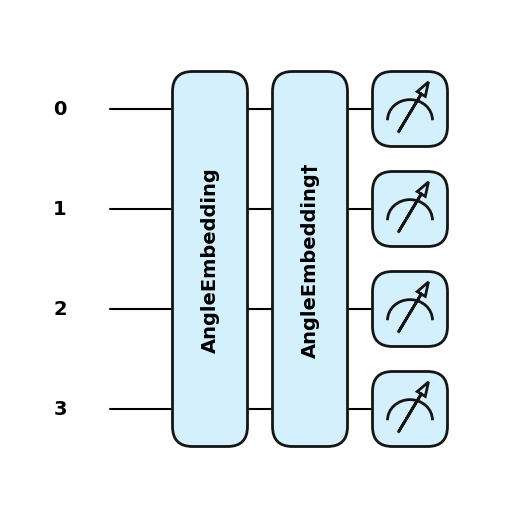

In [59]:
with dev_kernel.tracker:
    predictions = svm.predict(X_test)
    print(y_train.shape)
    print(y_test.shape)
    model_acc = accuracy_score(y_test,predictions,)
    print(type(model).__name__, " accuracy is ", model_acc)
    print(confusion_matrix(y_test, predictions))

dev_kernel.tracker.totals['executions']